# Vision Transformer with Pytorch (CPU)

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
import torchvision.models as models

import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

Prepare Data

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data_path = '../VIT-dog-cat/data/dataset_treino_e_teste/train'
test_data_path = '../VIT-dog-cat/data/dataset_treino_e_teste/test'

train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Import pretrained model

In [4]:
model = models.vit_l_32(pretrained=True)

d:\AREA_DE_TRABALHO\Faculdade_7_Periodo\TCC1\VIT-dog-cat\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AREA_DE_TRABALHO\Faculdade_7_Periodo\TCC1\VIT-dog-cat\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine Tuning

In [5]:
# last_layer_name, last_layer = list(model.named_modules())[-1]
# num_features = last_layer.in_features
# setattr(model, last_layer_name, nn.Linear(num_features, 2))

for name, layer in model.named_modules():
    if isinstance(layer, nn.Linear):
        num_features = layer.in_features
        break
      
model.head = nn.Sequential(
    nn.Linear(num_features, 1),  
    nn.Sigmoid()  
)

In [8]:
for name, param in model.named_parameters():
    if name.startswith('head'):
        param.requires_grad = True  
    else:
        param.requires_grad = False

Train the model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 3
total_steps = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
  
    running_loss = 0.0
    correct_train = 0
    total_train = 0
  
    model.train()
    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # Convertendo labels para one-hot
        labels_one_hot = torch.zeros_like(outputs)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = correct_train / total_train
        if step == total_steps:
          print("----------------X------------------")
          break

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{total_steps}], Loss: {loss.item():.4f}, Acurracy Train: {train_accuracy:.4f}')
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    
torch.save(model.state_dict(), './models/modelo_vit_cpu.pth')

Epoch [1/3], Step [1/5], Loss: 0.3666, Acurracy Train: 0.0000
Epoch [1/3], Step [2/5], Loss: 0.3369, Acurracy Train: 0.0000
Epoch [1/3], Step [3/5], Loss: 0.3201, Acurracy Train: 0.0000
Epoch [1/3], Step [4/5], Loss: 0.2636, Acurracy Train: 0.0000
Epoch [1/3], Step [5/5], Loss: 0.2300, Acurracy Train: 0.0000
----------------X------------------
Epoch [1/3], Loss: 0.2980
Epoch [2/3], Step [1/5], Loss: 0.2350, Acurracy Train: 0.0156
Epoch [2/3], Step [2/5], Loss: 0.2042, Acurracy Train: 0.0234
Epoch [2/3], Step [3/5], Loss: 0.2096, Acurracy Train: 0.0260
Epoch [2/3], Step [4/5], Loss: 0.1822, Acurracy Train: 0.0391
Epoch [2/3], Step [5/5], Loss: 0.1908, Acurracy Train: 0.0469
----------------X------------------
Epoch [2/3], Loss: 0.2068
Epoch [3/3], Step [1/5], Loss: 0.1610, Acurracy Train: 0.0938
Epoch [3/3], Step [2/5], Loss: 0.1526, Acurracy Train: 0.1250
Epoch [3/3], Step [3/5], Loss: 0.1543, Acurracy Train: 0.1250
Epoch [3/3], Step [4/5], Loss: 0.1557, Acurracy Train: 0.1445
Epoch [3

In [ ]:
# Validation
model.eval()
running_val_loss = 0.0
correct_val = 0
total_val = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        labels_one_hot = torch.zeros_like(outputs)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
        
        loss = criterion(outputs, labels_one_hot)
        
        running_val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

val_loss = running_val_loss / len(test_loader)
val_accuracy = correct_val / total_val
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)

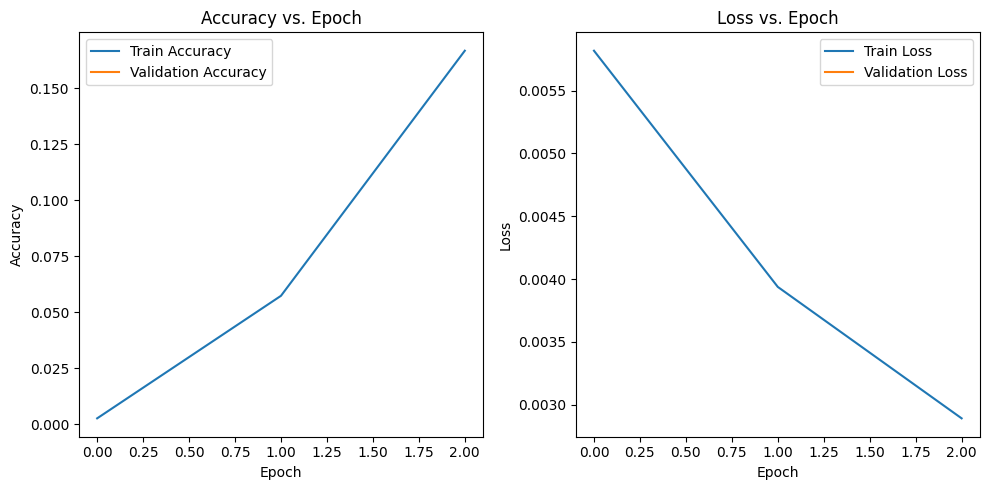

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Validate

In [7]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from transformers import ViTForImageClassification

state_dict = torch.load('../VIT-dog-cat/models/modelo_vit_gpu.pth', map_location=torch.device('cpu'))
model_state_dict = model.state_dict()

state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

model.load_state_dict(state_dict, strict=False)


transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.CenterCrop(224),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


In [30]:
image_path = '../VIT-dog-cat/data/dataset_treino_e_teste/validation/Dog/1000.jpg'  
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)  

import torch.nn.functional as F
with torch.no_grad():
    output = model(image)
    probabilities = F.sigmoid(output.logits)

print("Classe prevista:",probabilities)

Classe prevista: tensor([[0.5801]])
